# Projeto Final

### Alunos: 

- Daniel da Rocha Carneiro

- Yago Cunha Martins

---

#### Importações

In [152]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.interpolate import interp1d

%matplotlib inline

#### Funções que implementam o rastreamento

In [153]:
def moving_average(data, window_size=40):
    cumsum = np.cumsum(np.insert(data, 0, 0))
    return (cumsum[window_size:] - cumsum[:-window_size]) / float(window_size)


def interpolate_curve(points):
    num_points = len(points)
    indices = np.linspace(0, num_points - 1, num=num_points)  # Use indices as 'time'

    x_values = np.array([point[0] for point in points])
    y_values = np.array([point[1] for point in points])

    # Calculate moving averages for x and y coordinates
    x_smoothed = moving_average(x_values)
    y_smoothed = moving_average(y_values)

    # Ensure equal lengths for x and y arrays
    min_len = min(len(x_smoothed), len(y_smoothed))
    x_smoothed = x_smoothed[:min_len]
    y_smoothed = y_smoothed[:min_len]

    # Perform interpolation for x and y coordinates separately using indices as 'time'
    interp_x = interp1d(indices[2:-2][:min_len], x_smoothed, kind='linear', fill_value='extrapolate')
    interp_y = interp1d(indices[2:-2][:min_len], y_smoothed, kind='linear', fill_value='extrapolate')

    # Generate a finer set of indices for interpolation
    finer_indices = np.linspace(2, min_len - 3, num=min_len)  # Adjusted based on the minimum length

    # Calculate corresponding x and y values using the interpolated functions
    interp_x_values = interp_x(finer_indices)
    interp_y_values = interp_y(finer_indices)

    # Plot the interpolated movement path with inverted axes
    plt.figure(figsize=(8, 6))
    plt.scatter(x_values[:min_len],y_values[:min_len] , label='Pontos rastreados', color='red')  # Swap x and y when plotting
    plt.plot(interp_x_values,interp_y_values,  label='Caminho interpolado', color='blue')  # Swap x and y for the interpolated values
    plt.gca().invert_yaxis()  # Invert the y-axis
    plt.legend()
    plt.xlabel('X-axis')  # Label as Y-axis since x and y are swapped
    plt.ylabel('Y-axis')  # Label as X-axis since x and y are swapped
    plt.title('Trajetória realizada no plano da imagem')
    plt.grid(True)
    plt.show()

In [154]:
def trackHusky(video_path, name, outpath, display):
    cap = cv.VideoCapture(video_path)

    #motion detection e background subtraction
    background_remover = cv.createBackgroundSubtractorKNN(detectShadows=True)

    frames = []
    max_cnts = []
    path = []

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        result = frame.copy()

        image = cv.cvtColor(frame, cv.COLOR_BGR2HSV)

        #####################################################################
        #===================================================================#
        #####################################################################

        #Filtro de cores
        lower_red = np.array([165,30,20])
        upper_red = np.array([189,255,255])

        colorMask = cv.inRange(image, lower_red, upper_red)
        red_isolated = cv.bitwise_and(result, result, mask=colorMask)


        #####################################################################
        #===================================================================#
        #####################################################################

        #Filtro da mesa

        rect_start = (0, 450)  # Top-left point of the rectangle
        rect_end = (600, 600)  # Bottom-right point of the rectangle
        recMask = np.zeros(image.shape[:2], dtype=np.uint8)

        # Draw a filled white rectangle on the mask
        cv.rectangle(recMask, rect_start, rect_end, (255), thickness=cv.FILLED)

        # Invert the mask using bitwise NOT
        inverse_recMask = cv.bitwise_not(recMask)

        # Apply the inverted mask to the image
        recMasked = cv.bitwise_and(result, result, mask=recMask)


        #Filtro do canto (pessoa que passa)


        triangleMask = np.zeros(image.shape[:2], dtype=np.uint8)  # Create a black mask with the same size as the frame
        triangle_vertices = np.array([(350, 600), (1000, 600), (1000, 270)])  # Triangle vertices

        # Draw a filled white triangle on the mask
        cv.fillPoly(triangleMask, [triangle_vertices], (255, 255, 255))
        inverse_triangleMask = cv.bitwise_not(triangleMask)

        combined_mask = cv.bitwise_and(inverse_recMask, inverse_triangleMask)  # Adjust the operation as needed


        combinedMasked = cv.bitwise_and(result, result, mask=combined_mask)





        combined = cv.bitwise_and(red_isolated, red_isolated, mask=combined_mask)
        #combined = cv.bitwise_and(red_isolated, red_isolated, mask=inverse_triangleMask)



        #####################################################################
        #===================================================================#
        #####################################################################

        #Tratamento para tracking



        #blur para reduzir ruido
        result = cv.GaussianBlur(combined, (5, 5), 0)
        
        #background subtraction e suavização com o operador morfológico da máscara resultante
        mask = background_remover.apply(colorMask)
        _, mask = cv.threshold(mask, 254, 255, cv.THRESH_BINARY)
        mask = cv.morphologyEx(mask, cv.MORPH_OPEN, np.ones((3,3),np.uint8)) 

        mask = cv.bitwise_and(mask, combined_mask)  # Adjust the operation as needed


        #blobs resultantes
        contours, _ = cv.findContours(mask, cv.RETR_TREE, cv.CHAIN_APPROX_NONE)

        #seleciona apenas o maior blob válido e desenhamos uma elipse sobre ele
        max_cnt = [0, 0]
        for cnt in contours:
            area = cv.contourArea(cnt)
            if area > 800 and len(cnt) >= 5:
                if area > max_cnt[0]:
                    max_cnt = [area, cnt]
        
        if max_cnt[0] != 0:
            elipse = cv.fitEllipse(max_cnt[1])
            path.append([int(elipse[0][0]), int(elipse[0][1])])
            cv.ellipse(frame, elipse, (0, 255, 0), 2)
            cv.ellipse(result, elipse, (0, 255, 0), 2)

        #caminho percorrido pelo blob
        for point in path:
            cv.circle(frame, (point[0], point[1]), 2, (255, 255, 255))
            cv.circle(result, (point[0], point[1]), 2, (255, 255, 255))


        #####################################################################
        #===================================================================#
        #####################################################################

        #salva os frames e os blobs
        if ret == True:
            frames.append(frame)
            max_cnts.append(max_cnt)


        #####################################################################
        #===================================================================#
        #####################################################################

        # Plot do vídeo

        # Create a 2x2 grid with the images
        top_row = np.hstack((red_isolated, combinedMasked))
        bottom_row = np.hstack((result, frame))  # Adding an empty placeholder
        combined_image = np.vstack((top_row, bottom_row))


        # Add labels for each video
        label1 = "Red Isolated"
        label2 = "Object mask"
        label3 = "Combined mask and tracking"
        label4 = "Final result"

        # Calculate positions for each label
        label1_x = 20
        label1_y = 30
        label2_x = combined.shape[1] + 20
        label2_y = 30
        label3_x = 20
        label3_y = combined.shape[0] + 30
        label4_x = combined.shape[1] + 20
        label4_y = result.shape[0] + 30

        # Add labels to each video
        cv.putText(combined_image, label1, (label1_x, label1_y), cv.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
        cv.putText(combined_image, label2, (label2_x, label2_y), cv.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
        cv.putText(combined_image, label3, (label3_x, label3_y), cv.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
        cv.putText(combined_image, label4, (label4_x, label4_y), cv.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

        # Show the resulting combined images
        if display == True:
            cv.imshow('Rastreamento Husky', combined_image)

            
        # Press 'q' to exit the video
        if cv.waitKey(1) & 0xFF == ord('q'):
            break

        

    cap.release()
    cv.destroyAllWindows()

    #salva os frames como video
    img = frames[5].copy()
    fourcc = cv.VideoWriter_fourcc(*'XVID')
    out = cv.VideoWriter(outpath + name + '.avi', fourcc, 20.0, (frames[0].shape[1], frames[0].shape[0]))
    for frame in frames:
        out.write(frame)
    out.release()

    #gera a imagem u,v e orientação
    step = 3
    colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255)]
    c_inc = 0
    for i in range(10, len(path)-10, step):
        u = path[i][0] - path[i-step][0]
        v = path[i][1] - path[i-step][1]
        orientation = np.arctan2(v, u)
        #check if length of line is too large (outlier => pescoço)
        if np.sqrt(u**2 + v**2) > 50:
            continue

        cv.arrowedLine(img, (path[i-step][0], path[i-step][1]), (path[i][0], path[i][1]), colors[c_inc%3], 1, tipLength=0.8)
        c_inc += 1

    cv.imwrite(outpath + name + '.png', img)

    img = mpimg.imread(outpath + name + '.png', img)
    plt.imshow(img)
    plt.axis('off')  # Turn off axis labels and ticks
    plt.title('u v e orientação')
    plt.show()


    interpolate_curve(path)
    
    return

# Chamar a função e fornecer o caminho do vídeo .avi
#isolar_vermelho('Video2_husky.mp4')


#### Execução

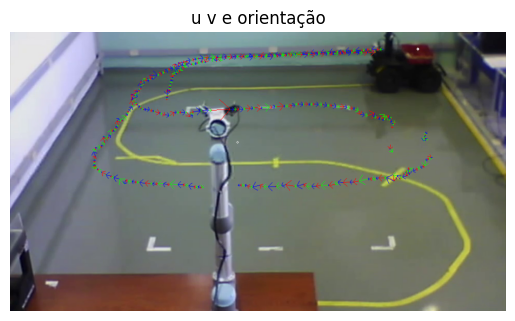

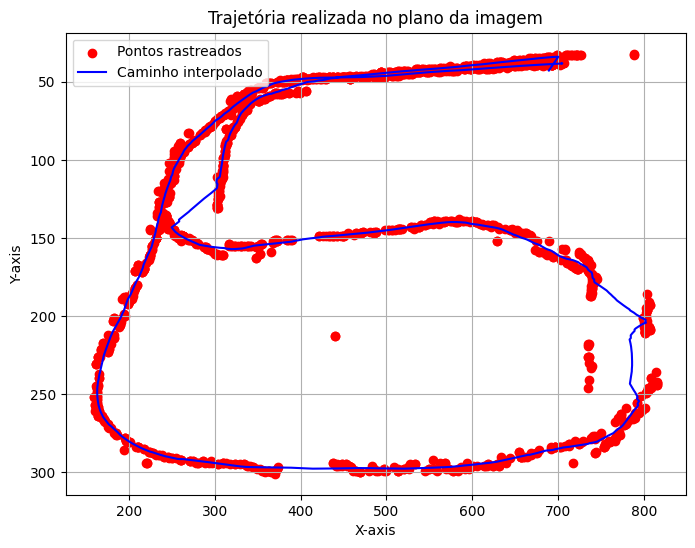

In [158]:
trackHusky('Video1_husky.mp4', 'husky1', 'output/', True)

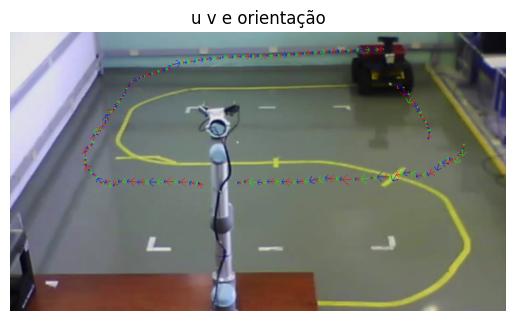

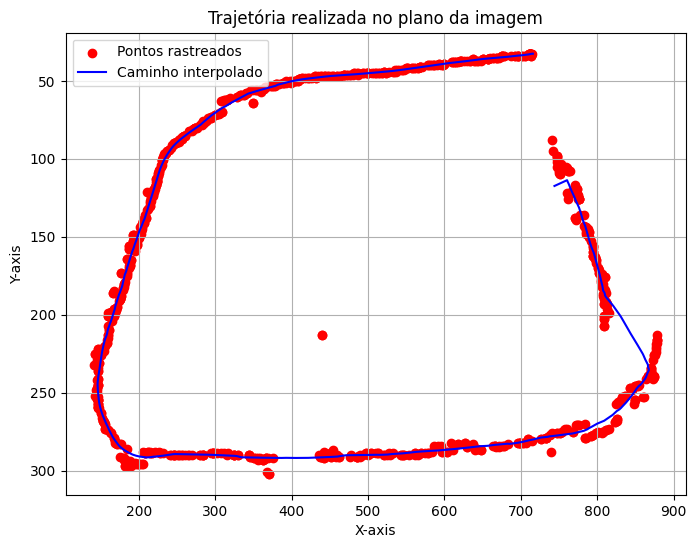

In [159]:
trackHusky('Video2_husky.mp4', 'husky2', 'output/', True)